In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import math
import shutil
import warnings
import random
import dlib
import cv2
import pickle

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import *

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

In [3]:
warnings.filterwarnings('ignore')

In [4]:
# Path to the dataset directory
dataset_dir = '/CelebLikeMe/105_classes_pins_dataset(labelled)/Fair/'

In [5]:
# Function to load images from a given directory
def load_images_from_directory(directory):
    image_paths = []
    roots = []
    for root, _, files in os.walk(directory):
          roots.append(root)
          for file in files:
              if file.endswith('.jpg'):
                  image_paths.append(os.path.join(root, file))
    return image_paths

In [6]:
# Load image paths from the dataset
image_paths = load_images_from_directory(dataset_dir)

In [7]:
# Display a random sample of images with celebrity names
def display_random_sample(image_paths, num_samples=5):
    random_sample = random.sample(image_paths, num_samples)
    plt.figure(figsize=(15, 5))
    for i, image_path in enumerate(random_sample):
        celebrity = image_path.split('/')[7]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(celebrity.replace("pins_", ''))  # Display celebrity name as title
    plt.suptitle('Random Sample of Images from the Dataset', fontsize=16)
    plt.show()


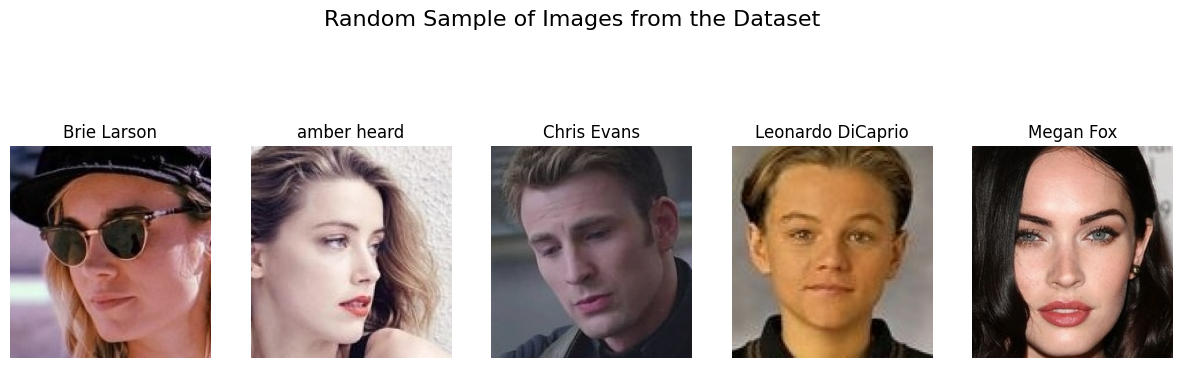

In [8]:
# Display a random sample of images with celebrity names
display_random_sample(image_paths)

In [9]:
# Count the number of images per celebrity
celeb_counts = {}
for image_path in image_paths:
    celebrity = image_path.split('/')[7]  # Extract celebrity name
    celebrity = celebrity.replace("pins_",'')
    celeb_counts[celebrity] = celeb_counts.get(celebrity, 0) + 1

# Sort the celebrities by the number of images they have
sorted_celebs = sorted(celeb_counts.items(), key=lambda x: x[1], reverse=True)

# Get the top 5 celebrities with the most images
top_5_celebs = sorted_celebs[:5]

# Extract celebrity names and image counts for the bar graph
celeb_names, image_counts = zip(*top_5_celebs)

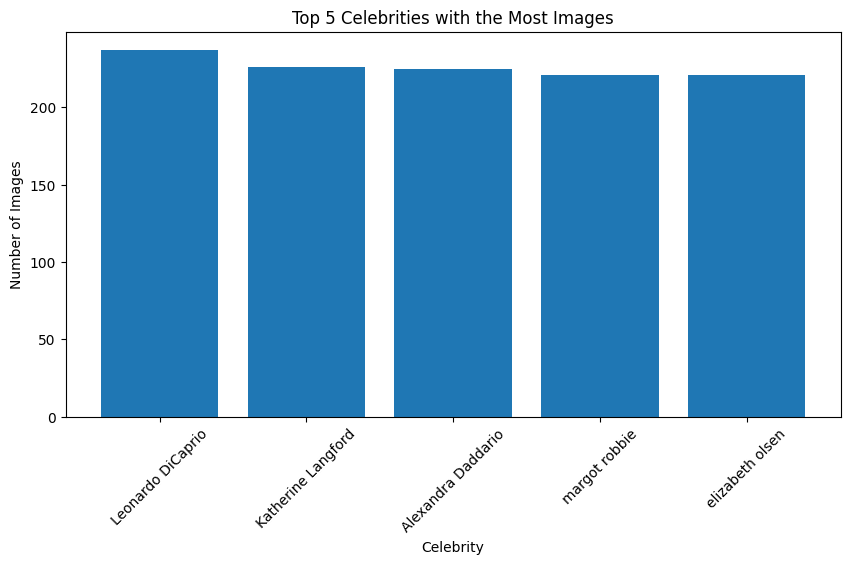

In [10]:
# Create a bar graph to show the top 5 celebrities with the most images
plt.figure(figsize=(10, 5))
plt.bar(celeb_names, image_counts)
plt.xlabel('Celebrity')
plt.ylabel('Number of Images')
plt.title('Top 5 Celebrities with the Most Images')
plt.xticks(rotation=45)
plt.show()

In [11]:
# Get the dimensions of the dataset
num_images = len(image_paths)
image_shape = cv2.imread(image_paths[0]).shape

In [12]:
print(f"Number of Images in the Dataset: {num_images}")
print(f"Dimensions of Each Image: {image_shape}")


Number of Images in the Dataset: 9235
Dimensions of Each Image: (221, 197, 3)


In [13]:
# Initialize the face detector and facial landmarks predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('./shape_predictor/shape_predictor_68_face_landmarks.dat')  # You need to download this model

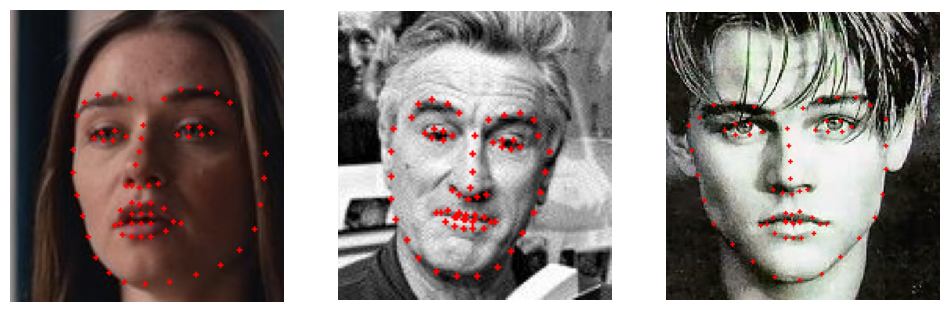

In [14]:
# Number of random samples to visualize
num_samples = 3

# Create a subplot grid for displaying images
fig, axes = plt.subplots(1, num_samples, figsize=(12, 4))

# Randomly select and visualize facial landmarks on sample images
for i in range(num_samples):
    # Randomly select an image
    random_image_path = random.choice(image_paths)

    # Load and process the selected image
    image = cv2.imread(random_image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = detector(gray)

    # Loop over detected faces and visualize facial landmarks
    for face in faces:
        landmarks = predictor(gray, face)
        landmarks = np.array([[landmarks.part(i).x, landmarks.part(i).y] for i in range(68)])

        # Draw landmarks on the image
        for (x, y) in landmarks:
            cv2.circle(image, (x, y), 1, (0, 0, 255), -1)

    # Display the image with facial landmarks using Matplotlib
    axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[i].axis('off')

# Show the plotted images
plt.show()


In [15]:
# VGG Face model
model = Sequential()
# Block-1
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

# Block-2
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

# Block-3
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

# Block-4
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

# Block-5
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

# Fully connected layers
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))

# Flatten the output
model.add(Flatten())
model.add(Activation('softmax'))

In [16]:
model.load_weights('/CelebLikeMe/faceweights/vgg_face_weights.h5')

In [17]:
faceDescriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [ ]:
# Initialize an empty array to store embeddings
num_samples = len(image_paths)
embedding_dim = 2622
embeddings = np.zeros((num_samples, embedding_dim))

# Loop through each image in the image_paths
for i, image_path in enumerate(image_paths):
    img_path = image_path

    # Load and preprocess the image
    img = cv2.imread(img_path, 1)
    img = img[..., ::-1]  # Convert from BGR to RGB
    img = (img / 255.).astype(np.float32)  # Normalize pixel values to [0, 1]
    img = cv2.resize(img, dsize=(224, 224))  # Resize the image to match model input size

    # Use the faceDescriptor model to extract embeddings
    embedding_vector = faceDescriptor.predict(np.expand_dims(img, axis=0))[0]

    # Store the embedding vector in the embeddings array
    embeddings[i] = embedding_vector
    print(i)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 26ms/step
6735
1/1 [==============================] - 0s 33ms/step
6736
1/1 [==============================] - 0s 31ms/step
6737
1/1 [==============================] - 0s 31ms/step
6738
1/1 [==============================] - 0s 28ms/step
6739
1/1 [==============================] - 0s 27ms/step
6740
1/1 [==============================] - 0s 19ms/step
6741
1/1 [==============================] - 0s 18ms/step
6742
1/1 [==============================] - 0s 21ms/step
6743
1/1 [==============================] - 0s 21ms/step
6744
1/1 [==============================] - 0s 28ms/step
6745
1/1 [==============================] - 0s 19ms/step
6746
1/1 [==============================] - 0s 19ms/step
6747
1/1 [==============================] - 0s 19ms/step
6748
1/1 [==============================] - 0s 18ms/step
6749
1/1 [==============================] - 0s 19ms/step
6750
1/1 [==============================] 

In [ ]:
#Uncomment After first use
np.save('/content/drive/MyDrive/Colab Notebooks/embeddings_fair.npy', embeddings)

In [ ]:

embeddings = np.load('./embeddings_fair.npy')

In [19]:
# Print the shape of the embeddings
print('Embeddings shape:', embeddings.shape)

Embeddings shape: (9235, 2622)


In [20]:
# Calculate the Euclidean distance between two embeddings.
def euclidean_distance(emb1, emb2):
    # Check if the input arrays have the same shape
    if emb1.shape != emb2.shape:
        raise ValueError("Input arrays must have the same shape")

    # Calculate the squared differences element-wise
    squared_diff = np.square(emb1 - emb2)

    # Sum the squared differences to get the Euclidean distance
    distance = np.sqrt(np.sum(squared_diff))

    return distance

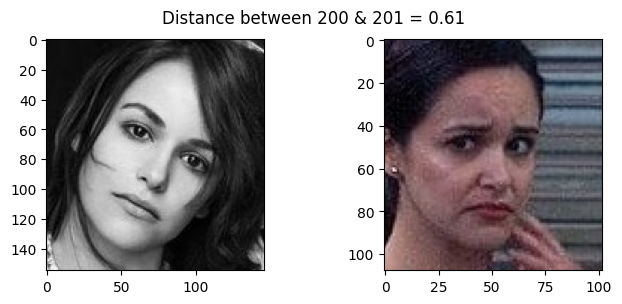

In [21]:
idx1 = 200
idx2 = 201

plt.figure(figsize=(8, 3))
plt.suptitle(f'Distance between {idx1} & {idx2} = {euclidean_distance(embeddings[idx1], embeddings[idx2]):.2f}')

plt.subplot(121)
plt.imshow(cv2.imread(image_paths[idx1], 1)[..., ::-1])

plt.subplot(122)
plt.imshow(cv2.imread(image_paths[idx2], 1)[..., ::-1])
plt.show()

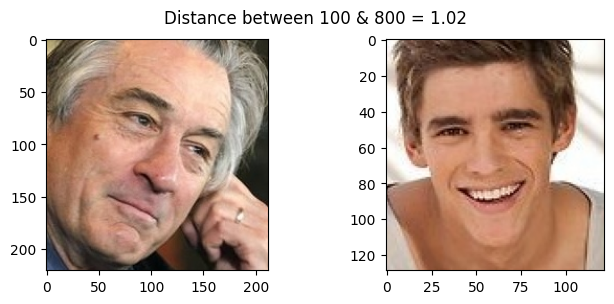

In [22]:
idx1 = 100
idx2 = 800

plt.figure(figsize=(8, 3))
plt.suptitle(f'Distance between {idx1} & {idx2} = {euclidean_distance(embeddings[idx1], embeddings[idx2]):.2f}')

plt.subplot(121)
plt.imshow(cv2.imread(image_paths[idx1], 1)[..., ::-1])

plt.subplot(122)
plt.imshow(cv2.imread(image_paths[idx2], 1)[..., ::-1])
plt.show()


In [23]:
labels = [image_path.split('/')[7].replace("pins_",'') for image_path in image_paths]
print(len(labels))

9235


In [24]:
# splititng the data for train and test
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.1)

In [25]:
print('X_train shape : ({0},{1})'.format(X_train.shape[0], X_train.shape[1]))
print('y_train shape : ({0},)'.format(np.array(y_train).shape[0]))
print('X_test shape : ({0},{1})'.format(X_test.shape[0], X_test.shape[1]))
print('y_test shape : ({0},)'.format(np.array(y_test).shape[0]))

X_train shape : (8311,2622)
y_train shape : (8311,)
X_test shape : (924,2622)
y_test shape : (924,)


In [26]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels in y_train and y_test
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [27]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the training features (X_train)
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [28]:
# Reduce dimensions using PCA
print('X_train_std shape : ({0},{1})'.format(X_train_std.shape[0], X_train_std.shape[1]))
print('y_train_encoded shape : ({0},)'.format(y_train_encoded.shape[0]))
print('X_test_std shape : ({0},{1})'.format(X_test_std.shape[0], X_test_std.shape[1]))
print('y_test_encoded shape : ({0},)'.format(y_test_encoded.shape[0]))

X_train_std shape : (8311,2622)
y_train_encoded shape : (8311,)
X_test_std shape : (924,2622)
y_test_encoded shape : (924,)


In [29]:
# Initialize PCA with the desired number of components (128 in this case)
pca = PCA(n_components=128)

# Fit and transform the standardized training features (X_train_std)
X_train_pca = pca.fit_transform(X_train_std)

# Transform the standardized test features (X_test_std) using the same PCA transformation
X_test_pca = pca.transform(X_test_std)

In [30]:
# Machine Learning Classifier
# Initialize the Support Vector Classifier with specified hyperparameters (C and gamma)
clf = SVC(C=5.0, gamma=0.001, probability=True)

In [31]:
# Fit the classifier to the training data with PCA-transformed features
clf.fit(X_train_pca, y_train_encoded)

SVC(C=5.0, gamma=0.001, probability=True)

In [32]:
# Make predictions on the test data using the trained classifier
y_predict = clf.predict(X_test_pca)

In [33]:
y_predict

array([35, 23, 28, 16, 47,  9, 42,  3, 40, 35,  2, 32, 11,  6, 20, 28, 43,
        5, 13,  4,  1, 11, 37, 23, 24, 35, 10, 39, 14, 32,  3, 33, 30,  9,
       16, 52, 45, 36,  0, 33, 37, 34, 41, 51, 21, 43, 32,  9, 41, 47, 51,
       30, 18, 22, 41,  4, 31, 51, 27, 52, 46, 33,  9, 37,  2, 27, 26, 42,
        2, 35, 44,  4, 20,  9, 46, 38, 41, 36, 17, 35, 20, 41, 40,  5, 15,
        5, 14, 50, 42, 22, 26, 48, 22, 19,  0, 35, 21, 15, 11, 22, 50, 14,
       48, 25, 10,  6, 34, 17, 47, 35, 47,  7, 40, 16,  3, 50, 28,  1, 45,
       47, 16, 23, 52, 45, 31, 24, 50, 22, 21, 23, 25, 14, 42, 46, 42, 15,
       42, 46, 14, 20, 14, 23, 49,  0,  9,  4, 42, 46, 36, 34,  0, 23, 42,
        0,  1, 17, 28,  7, 32, 27, 29, 49,  9,  2, 43, 43,  6, 14, 18, 50,
       14, 45, 52, 50,  2, 47, 19, 43, 30, 12, 20,  2,  9, 49, 26,  6, 46,
       16, 36, 44, 14, 43, 24, 14, 42, 52, 17,  3, 52, 20, 42, 51, 26, 25,
       48, 14,  1, 14, 10,  0, 14, 52,  9, 51,  6, 51, 32, 30, 40, 10,  7,
        3, 11,  6, 43, 22

In [34]:
y_test_encoded

array([44, 23, 28, 16, 47,  9, 42,  3, 40, 51,  2, 32, 11,  6, 20, 28, 43,
        5, 13,  4,  1, 11, 37, 23, 24, 35, 10, 39, 14, 32,  3, 33, 30,  9,
       16, 52, 45, 36,  0, 33, 37, 34, 41, 51, 21, 43, 32,  9, 41, 47, 51,
       30, 18, 22, 41,  4, 31, 51, 27, 52, 46, 33,  9, 37,  2, 27, 26, 42,
        2, 35, 44,  4, 20,  9, 46, 38, 41, 36, 17,  2, 20, 41, 40,  5, 15,
        5, 14, 50, 42, 22, 26, 48, 22, 19,  0, 20, 21, 15, 11, 22, 50, 14,
       48, 25, 10,  6, 34, 17, 47, 35, 47,  7, 40, 16,  3, 50, 28,  1, 45,
       47, 16, 23, 52, 45, 31, 24, 50, 22, 21, 23, 25, 14, 42, 46, 17, 15,
       42, 46, 14, 20, 14, 23, 49,  0,  9,  4, 42, 46, 36, 34,  0, 23, 42,
        0,  1, 17, 28,  7, 32, 27, 29, 49,  9,  2, 43, 43,  6, 14, 18, 50,
       14, 45,  3, 13,  2, 47, 19, 43, 30, 12, 20,  2,  9, 49, 26,  6, 46,
       16, 36, 44, 14, 43, 42, 14, 42, 52, 17,  3, 52, 20, 42, 51, 26, 25,
       48, 14,  1, 14, 10,  0, 14, 52,  9, 51,  6, 51, 32, 30, 40, 10,  7,
        3, 11, 22, 43, 22

In [35]:
# Calculate accuracy score
accuracy = accuracy_score(y_test_encoded, y_predict)

# Calculate precision for each class
precision = precision_score(y_test_encoded, y_predict, average='weighted')

# Generate a classification report
classification_rep = classification_report(y_test_encoded, y_predict)

In [36]:
# Print the results
print("Accuracy:", accuracy)
print("Precision (weighted):", precision)
print("Classification Report:\n", classification_rep)

Accuracy: 0.9632034632034632
Precision (weighted): 0.9658341562289412
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       1.00      0.95      0.98        22
           2       1.00      0.96      0.98        24
           3       1.00      0.94      0.97        18
           4       1.00      0.94      0.97        16
           5       1.00      1.00      1.00        16
           6       0.88      1.00      0.94        15
           7       0.93      0.88      0.90        16
           8       0.93      1.00      0.97        14
           9       1.00      0.91      0.95        22
          10       0.95      1.00      0.97        19
          11       1.00      1.00      1.00        12
          12       1.00      1.00      1.00         9
          13       1.00      0.92      0.96        12
          14       0.97      0.97      0.97        29
          15       1.00      1.00      1.

In [37]:
# Load and preprocess the test image
img = cv2.imread(image_paths[41], 1)
img = img[..., ::-1]  # Convert from BGR to RGB
img = (img / 255.).astype(np.float32)  # Normalize pixel values to [0, 1]
img = cv2.resize(img, dsize=(224, 224))  # Resize the image to match model input size

# Use the faceDescriptor model to extract embeddings
embedding_vector = faceDescriptor.predict(np.expand_dims(img, axis=0))[0]

1/1 [==============================] - 7s 7s/step


In [38]:
scaledData = scaler.transform([embedding_vector])
pcaData = pca.transform(scaledData)

In [39]:
predictedLabel = clf.predict(pcaData)
predictedScore = clf.predict_proba(pcaData)

In [40]:
celebrityName = label_encoder.inverse_transform(predictedLabel)

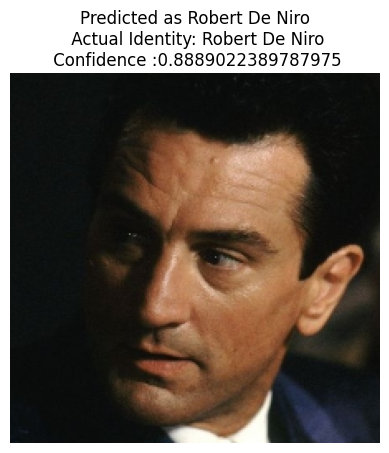

In [41]:
# Get the prediction and identity for the example
example_prediction = celebrityName[0]
example_identity = labels[41]

# Display the example image with a title
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted as {example_prediction}\n Actual Identity: {example_identity}\n Confidence :{max(predictedScore[0])}')
plt.show()


In [42]:
# save the neccessary model files
faceDescriptor.save("/vggModel_fair.pkl")
pickle.dump(scaler, open("/scaler_fair.pkl", "wb"))
pickle.dump(pca, open("/pca_fair.pkl", "wb"))
pickle.dump(clf, open("/svmModel_fair.pkl", "wb"))
pickle.dump(label_encoder, open("/label_encoder_fair.pkl", "wb"))